# Implémentez un modèle de scoring


 Projet 7


## enironnement
Kernel avec GPU pour effectuer les modélisations Catboost, LightGBM & XGBoost.

---

import sys
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile


from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import decomposition
import pickle
%pylab inline
import warnings
warnings.filterwarnings("ignore")

In [1]:
import sys
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile

from imblearn.under_sampling import NearMiss

from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import decomposition
import pickle
%pylab inline
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Test de l'activation du GPU
#Si le GPU est activé, il donnera la sortie suivante - '/ device: GPU: 0 '
import tensorflow as tf
tf.test.gpu_device_name ()


''

---

In [3]:
#!git clone --recursive https://github.com/Microsoft/LightGBM

In [4]:
#!LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu

In [5]:
#!pip install catboost 

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
train = pd.read_csv("../input/fichier-clean/train.csv")


In [8]:

train.shape

(307511, 123)

In [9]:
TARGET = train['TARGET']
TARGET.shape
del(train['TARGET'])

#ACP

In [10]:
X=train

In [11]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA(n_components=3)
pca.fit(X_scaled)

PCA(n_components=3)

In [12]:
X_scaled

array([[-1.73204518, -1.73204518, -0.32439532, ..., -0.45699805,
        -0.47575697, -0.98954538],
       [-1.73203391, -1.73203391, -0.32439532, ..., -0.45699805,
        -0.47575697, -1.09292674],
       [-1.73202265, -1.73202265,  3.08265852, ..., -0.45699805,
        -0.47575697, -1.09292674],
       ...,
       [ 1.73202265,  1.73202265, -0.32439532, ..., -0.33821013,
        -0.47575697, -0.98954538],
       [ 1.73203391,  1.73203391, -0.32439532, ..., -0.45699805,
        -0.47575697, -1.09292674],
       [ 1.73204518,  1.73204518, -0.32439532, ...,  0.96845696,
        -0.47575697, -0.98954538]])

In [13]:
X_scaled

array([[-1.73204518, -1.73204518, -0.32439532, ..., -0.45699805,
        -0.47575697, -0.98954538],
       [-1.73203391, -1.73203391, -0.32439532, ..., -0.45699805,
        -0.47575697, -1.09292674],
       [-1.73202265, -1.73202265,  3.08265852, ..., -0.45699805,
        -0.47575697, -1.09292674],
       ...,
       [ 1.73202265,  1.73202265, -0.32439532, ..., -0.33821013,
        -0.47575697, -0.98954538],
       [ 1.73203391,  1.73203391, -0.32439532, ..., -0.45699805,
        -0.47575697, -1.09292674],
       [ 1.73204518,  1.73204518, -0.32439532, ...,  0.96845696,
        -0.47575697, -0.98954538]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, TARGET, test_size=0.3, random_state=42)

### **Baseline model - Logistic Regression**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
def cf_matrix_roc_auc(X,model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    confmat.append(cf_matrix)
    show()


NearMiss sampling_strategy : 0.1
Label 1, After : 17412
Label 0, After : 174120
AUC : 0.7132
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84841
           1       0.29      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.61      0.50      0.48     92254
weighted avg       0.87      0.92      0.88     92254



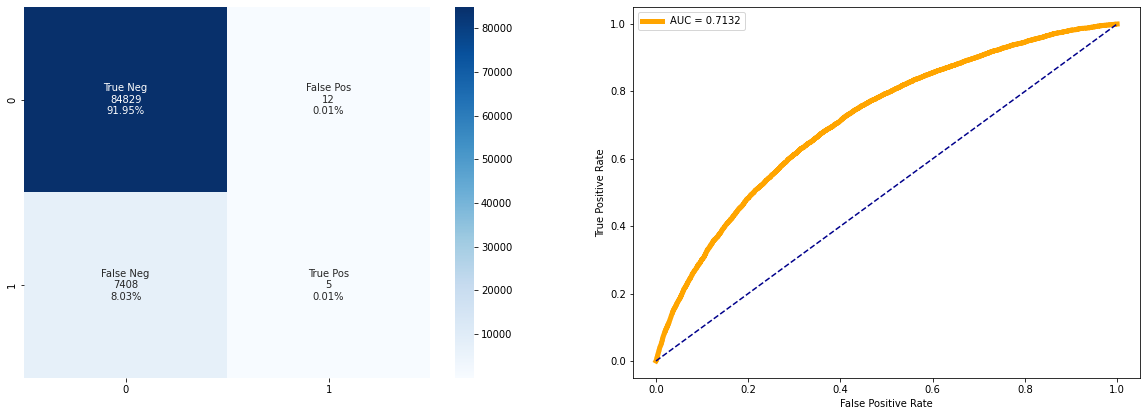

NearMiss sampling_strategy : 0.2
Label 1, After : 17412
Label 0, After : 87060
AUC : 0.5840
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     84841
           1       0.12      0.16      0.14      7413

    accuracy                           0.84     92254
   macro avg       0.52      0.53      0.52     92254
weighted avg       0.86      0.84      0.85     92254



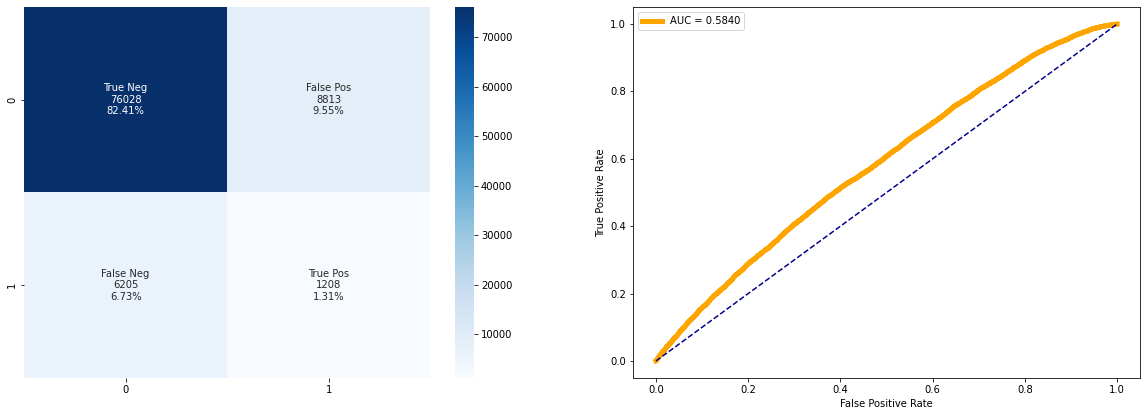

NearMiss sampling_strategy : 0.3
Label 1, After : 17412
Label 0, After : 58040
AUC : 0.5529
              precision    recall  f1-score   support

           0       0.93      0.68      0.78     84841
           1       0.09      0.38      0.15      7413

    accuracy                           0.66     92254
   macro avg       0.51      0.53      0.47     92254
weighted avg       0.86      0.66      0.73     92254



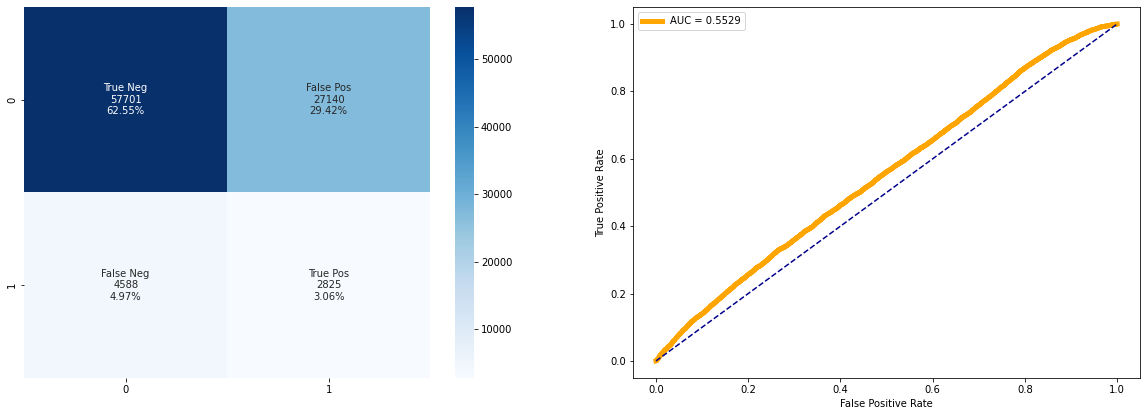

NearMiss sampling_strategy : 0.4
Label 1, After : 17412
Label 0, After : 43530
AUC : 0.5399
              precision    recall  f1-score   support

           0       0.92      0.53      0.67     84841
           1       0.09      0.51      0.15      7413

    accuracy                           0.53     92254
   macro avg       0.51      0.52      0.41     92254
weighted avg       0.86      0.53      0.63     92254



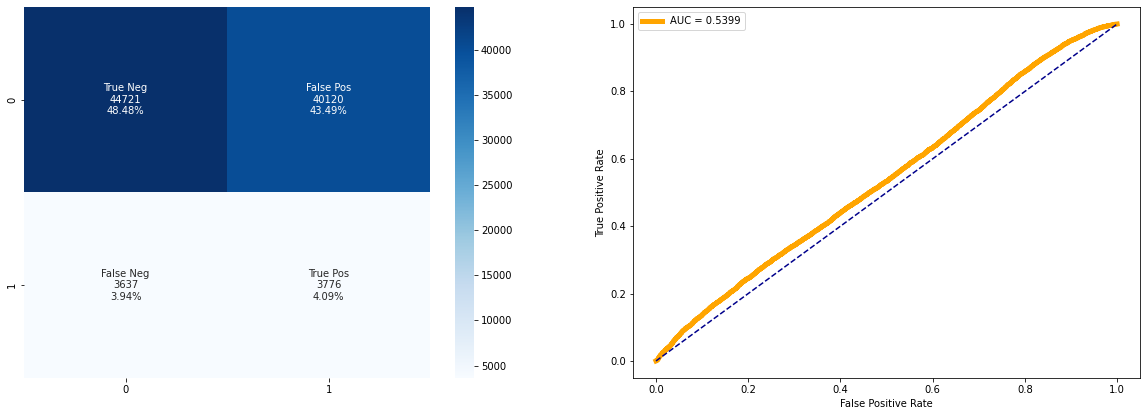

NearMiss sampling_strategy : 0.5
Label 1, After : 17412
Label 0, After : 34824
AUC : 0.5332
              precision    recall  f1-score   support

           0       0.92      0.44      0.60     84841
           1       0.08      0.58      0.15      7413

    accuracy                           0.45     92254
   macro avg       0.50      0.51      0.37     92254
weighted avg       0.86      0.45      0.56     92254



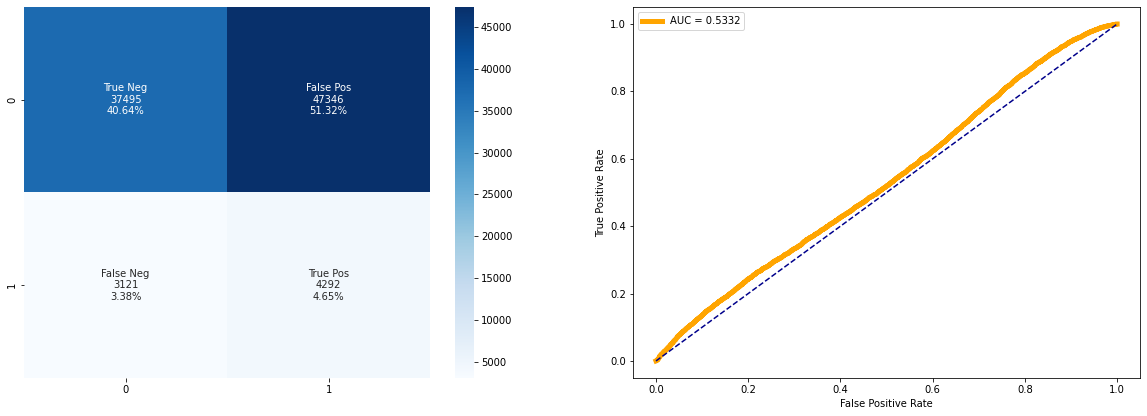

NearMiss sampling_strategy : 0.6
Label 1, After : 17412
Label 0, After : 29020
AUC : 0.5281
              precision    recall  f1-score   support

           0       0.92      0.39      0.55     84841
           1       0.08      0.62      0.15      7413

    accuracy                           0.41     92254
   macro avg       0.50      0.51      0.35     92254
weighted avg       0.86      0.41      0.52     92254



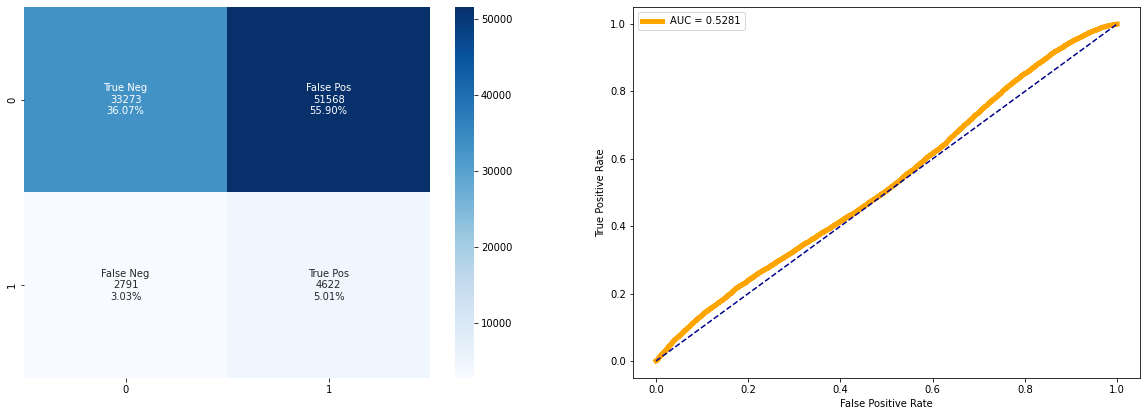

NearMiss sampling_strategy : 0.7
Label 1, After : 17412
Label 0, After : 24874
AUC : 0.5242
              precision    recall  f1-score   support

           0       0.92      0.36      0.51     84841
           1       0.08      0.66      0.15      7413

    accuracy                           0.38     92254
   macro avg       0.50      0.51      0.33     92254
weighted avg       0.86      0.38      0.48     92254



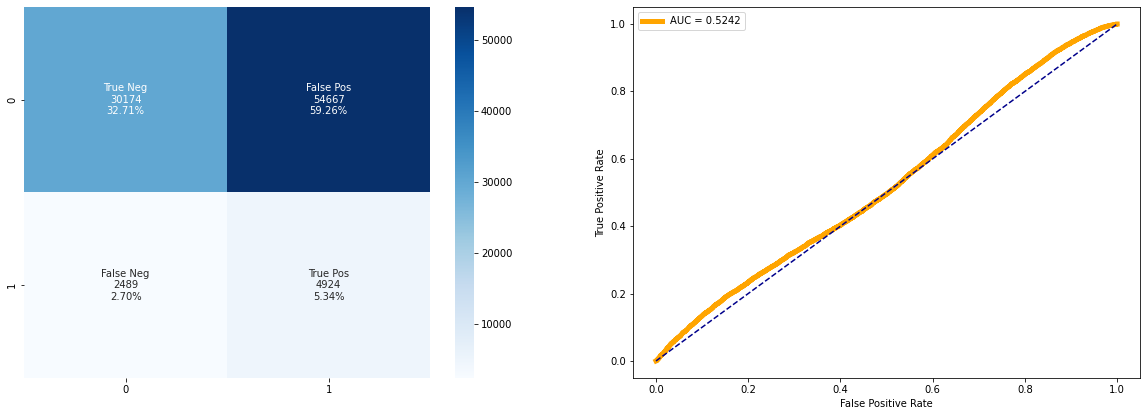

NearMiss sampling_strategy : 0.8
Label 1, After : 17412
Label 0, After : 21765
AUC : 0.5213
              precision    recall  f1-score   support

           0       0.93      0.33      0.48     84841
           1       0.08      0.70      0.15      7413

    accuracy                           0.36     92254
   macro avg       0.50      0.51      0.32     92254
weighted avg       0.86      0.36      0.46     92254



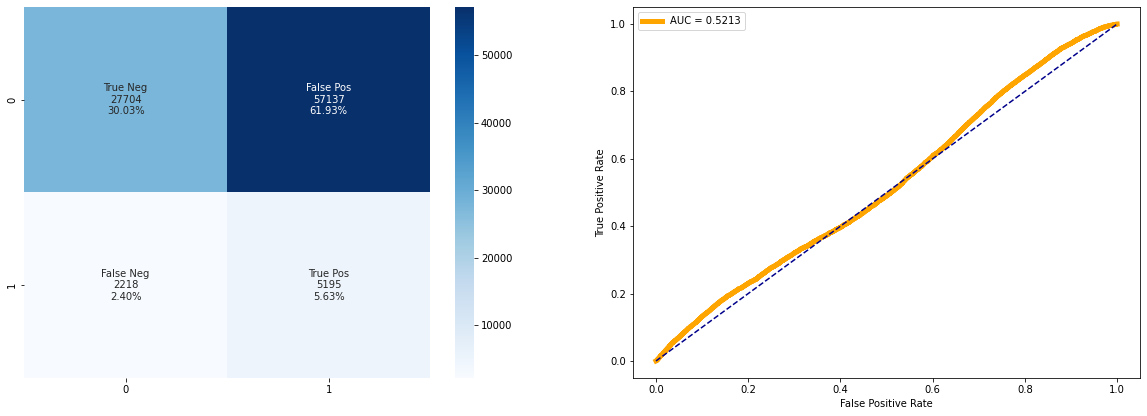

NearMiss sampling_strategy : 0.9
Label 1, After : 17412
Label 0, After : 19346
AUC : 0.5192
              precision    recall  f1-score   support

           0       0.93      0.30      0.45     84841
           1       0.08      0.73      0.15      7413

    accuracy                           0.33     92254
   macro avg       0.51      0.52      0.30     92254
weighted avg       0.86      0.33      0.43     92254



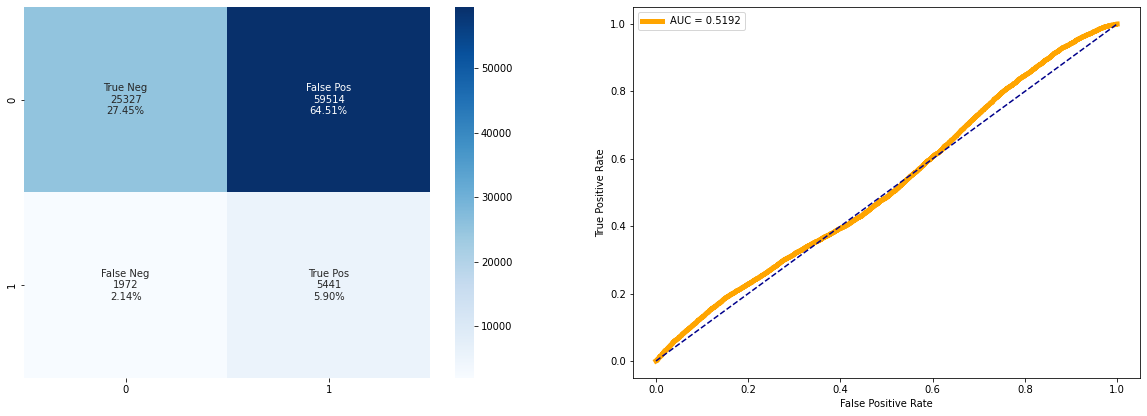

In [17]:
yafter1=[]
yafter0=[]
confmat=[]

for bcl in range(1,10):

    
    nm = NearMiss(sampling_strategy=bcl/10)
    X_train_res, y_train_res = nm.fit_resample(X_train, y_train)

    yafter1.append(sum(y_train_res==1))
    yafter0.append(sum(y_train_res==0))
    print("NearMiss sampling_strategy : {}".format(bcl/10))
    print("Label 1, After : {}".format(sum(y_train_res==1)))
    print("Label 0, After : {}".format(sum(y_train_res==0)))
    
    lr = LogisticRegression(C = 0.0001, max_iter=100)
    lr.fit(X_train_res, y_train_res)
    roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    print('AUC : %0.4f' %roc_auc)
    print(classification_report(y_test, lr.predict(X_test)))

    cf_matrix_roc_auc(X,lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)


In [18]:
confmat

[array([[84829,    12],
        [ 7408,     5]]),
 array([[76028,  8813],
        [ 6205,  1208]]),
 array([[57701, 27140],
        [ 4588,  2825]]),
 array([[44721, 40120],
        [ 3637,  3776]]),
 array([[37495, 47346],
        [ 3121,  4292]]),
 array([[33273, 51568],
        [ 2791,  4622]]),
 array([[30174, 54667],
        [ 2489,  4924]]),
 array([[27704, 57137],
        [ 2218,  5195]]),
 array([[25327, 59514],
        [ 1972,  5441]])]

[array([[84829,    12],
        [ 7408,     5]]),
 array([[76028,  8813],
        [ 6205,  1208]]),
 array([[57701, 27140],
        [ 4588,  2825]]),
 array([[44721, 40120],
        [ 3637,  3776]]),
 array([[37495, 47346],
        [ 3121,  4292]]),
 array([[33273, 51568],
        [ 2791,  4622]]),
 array([[30174, 54667],
        [ 2489,  4924]]),
 array([[27704, 57137],
        [ 2218,  5195]]),
 array([[25327, 59514],
        [ 1972,  5441]])]

In [19]:
yafter1=[17412, 17412, 17412, 17412, 17412, 17412, 17412, 17412, 17412]

In [20]:
yafter0=[174120, 87060, 58040, 43530, 34824, 29020, 24874, 21765, 19346]
a=yafter0


Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

**Oversampling Data Using SMOTE**

SMOTE with Imbalance Data using imblearn module



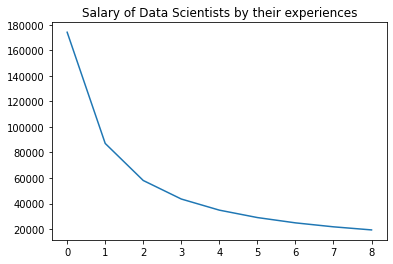

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime, timedelta #It's for time series

plt.plot(yafter0)
plt.title("Salary of Data Scientists by their experiences")
plt.show()

In [22]:
#%%time
#sm = smote = SMOTE(sampling_strategy=0.5)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [23]:
#print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
#print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

In [24]:
17412*100/87060




20.0

### exit


Sauvegarde du model

**LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time.** CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.